# Calculate ocean thermal forcing from ECCOv4r4 data, direct from PO.DAAC S3 storage

## Objective
To calculate ocean thermal forcing from ECCOv4r4 data, which can be used as forcing for marine-terminating glaciers (e.g., in an ice sheet model).

## Introduction
This notebook calculates ocean thermal forcing from ECCOv4r4 data by reading the data directly from the PO.DAAC S3 data bucket in the Amazon Web Services (AWS) us-west-2 region. To do this, the notebook must be run from a JupyterHub environment also located on us-west-2. By reading data directly from the S3 bucket, we do not have to maintain our own copy and do not need to download the ECCOv4r4 data products, avoiding the need to store the data locally and paying AWS data egress charges.

### Configuring Earthdata Authentication
To read the data from the PO.DAAC S3 bucket, you will need to setup Earthdata authentication. A set of functions are included below to facilitate this (compiled from multiple sources, listed below). You can automate authentication by creating a ".netrc" file in your home directory and writing the following to this file:

```
machine urs.earthdata.nasa.gov
    login <earthdata username>
    password <earthdata password>
```

On a JupyterHub, it is recommended that you do this from a terminal. First make sure you are in your home directory (`cd ~`), then create a new file and include the following:

```
cat >> .netrc
machine urs.earthdata.nasa.gov
    login <username>
    password <password>

```

Press `Enter` and then type `Ctrl+C` to save and close the prompt.

> **⚠️ Warning:** After writing the file, we _**strongly**_ recommend setting the new `.netrc` file to read-only for only the user using `chmod 0400 .netrc`. If you later need to edit this file, you can temporarily allow read/write by only the user with `chmod 0600 .netrc`. **NOTE:** Some users have found that they must reset the 0400 permissions every time they launch a JupyterHub. If you find this to be the case, you can simply add the correct command to your bash profile or else run the first cell in this notebook. Alternatively, you may wish to forego using a .netrc file altogether and instead use the login prompt below to authenticate each time you use this notebook. _However, that prompt appears to be broken at this time..._

If configured successfully, you should see the following output from the second notebook cell.

```
# Your URS credentials were securely retrieved from your .netrc file.
Earthdata login credentials configured. Ready.
```

Otherwise, you will see a message saying it could not use the .netrc file and it will ask you to input your username and password.

```
There's no .netrc file or the The endpoint isn't in the netrc file. Please provide...
# Your info will only be passed to urs.earthdata.nasa.gov and will not be exposed in Jupyter.
Username: 
```

---

*Note: There is a pip package called "earthdata" that is supposed to help with this process, primarily in reducing code that we must write. This package may be useful but is not used here.*

---

Sources:

- [Use Case: Study Amazon Estuaries with Data from the EOSDIS Cloud](https://github.com/podaac/tutorials/blob/master/notebooks/SWOT-EA-2021/Estuary_explore_inCloud_zarr.ipynb)
- [SWOT Oceanography with PO.DAAC](https://git.mysmce.com/eis-sealevel/swot/-/blob/main/tutorials/.ipynb_checkpoints/SWOT_simulated_L2_SSH_introduction-checkpoint.ipynb)
- ["Update cloud_direct_access_s3.py" - podaac tutorials commit 4da70c7cf079ddd7a6de4c4345749f580ba66d71](https://github.com/podaac/tutorials/commit/4da70c7cf079ddd7a6de4c4345749f580ba66d71#)

## Setup

In [1]:
# Set the right permissions on the ~/.netrc file (created using instructions above)
!chmod 0400 ~/.netrc

In [2]:
# Module imports
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import progressbar

from urllib import request
from http.cookiejar import CookieJar
import netrc
import requests
import s3fs
import getpass

# This package is the Python implementation of the Thermodynamic Equation of Seawater 2010 (TEOS-10)
# DOI: https://doi.org/10.5281/zenodo.4631363
# It can be installed using: !pip install gsw
import gsw

In [3]:
# Define some useful functions
def setup_earthdata_login_auth(endpoint):
    """
    Set up the request library so that it authenticates against the given Earthdata Login
    endpoint and is able to track cookies between requests.  This looks in the .netrc file 
    first and if no credentials are found, it prompts for them.
    Valid endpoints:
        urs.earthdata.nasa.gov - Earthdata Login production
    """
    try:
        username, _, password = netrc.netrc().authenticators(endpoint)
        print('# Your URS credentials were securely retrieved from your .netrc file.')
    except (FileNotFoundError, TypeError):
        # FileNotFound = There's no .netrc file
        # TypeError = The endpoint isn't in the netrc file, causing the above to try unpacking None
        print('There is no .netrc file or the The endpoint is not in the netrc file. Please provide...')
        print('# Your info will only be passed to %s and will not be exposed in Jupyter.' % (endpoint))
        username = input('Username: ')
        password = getpass.getpass('Password: ')

    manager = request.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, endpoint, username, password)
    auth = request.HTTPBasicAuthHandler(manager)

    jar = CookieJar()
    processor = request.HTTPCookieProcessor(jar)
    opener = request.build_opener(auth, processor)
    request.install_opener(opener)
    
def begin_s3_direct_access():
    url='https://archive.podaac.earthdata.nasa.gov/s3credentials'
    r = requests.get(url)
    response = r.json()
    return s3fs.S3FileSystem(key=response['accessKeyId'],secret=response['secretAccessKey'],token=response['sessionToken'],client_kwargs={'region_name':'us-west-2'})

# Get Earthdata login (EDL) credentials
edl = 'urs.earthdata.nasa.gov'
setup_earthdata_login_auth(edl)
print('Earthdata login credentials configured. Ready.')

# Your URS credentials were securely retrieved from your .netrc file.
Earthdata login credentials configured. Ready.


In [4]:
# Define a function to calculate ocean thermal forcing:
# Here, we use the p_from_z function from the Python gsw package that approximates pressure as a function of depth and latitude

def thermal_forcing(lat, depth, theta, salt):
    # This calculation of ocean thermal forcing is taken from Xu et al. (2012): https://doi.org/10.3189/2012AoG60A139
    
    # Local freezing point calculation
    a = -0.0575 # degC psu^-1
    b = 0.0901 # degC
    c = -7.61e-4 # degC dbar^-1
    
    rho_seawater = 1026 # kg m^-3
    g = 9.18 # m s^-2
    
    p = gsw.p_from_z(depth, lat) # dbar
    
    T_freeze = a*salt + b + c*p
    thermal_forcing = theta - T_freeze
    
    return thermal_forcing


## Setup
Set up the bounding box within which we'll calculate thermal forcing. First, we define an upper-left (ul) and a lower-right (lr) map location for the bounding box. Second, we define a minimum and maximum depth.

In the example below, we are defining a bounding box for Disko Bay, Greenland. **A cautionary note:** because ECCOv4 has 1-degree spatial resolution, the heat transfer in and out of Disko Bay may not be properly captured in the model.

In [5]:
# Disko Bay, Greenland
regionname = 'DiskoBay'
ul = [-55.0, 70.0]
lr = [-50.5, 67.5]

depth_min = -200
depth_max = -400


## Initial check -- initiate S3 access and load one ECCO dataset

Here, we initiate S3 access, then use s3fs to tell us what netcdf files are available in the given S3 bucket (printing out the last 5 for good measure). Then we select the last file and load it using xarray. Alternatively, you could attempt to use "harmony" to convert it to zarr format and load things from there (see the first source document above for more details).

In [6]:
# Initiate PO.DAAC S3 connection
fs = begin_s3_direct_access()

Now, load one file (from Jan. 1992) to test whether we're able to read from S3. As a sanity check, plot the ECCO ocean potential temperature at the surface from 1992 (start of the ECCO model data) and from 2017 (end of the ECCO model data), as well as our bounding box.

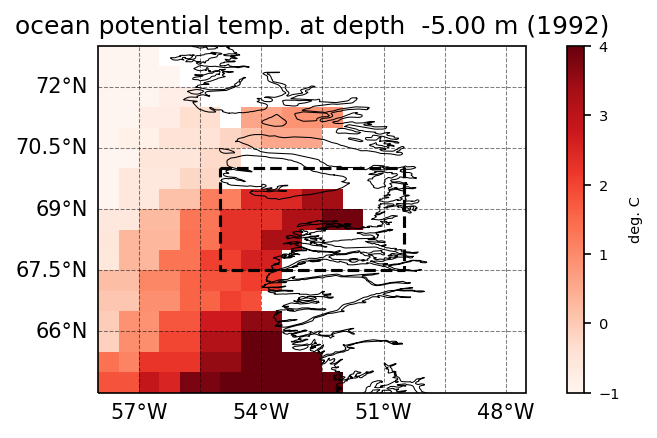

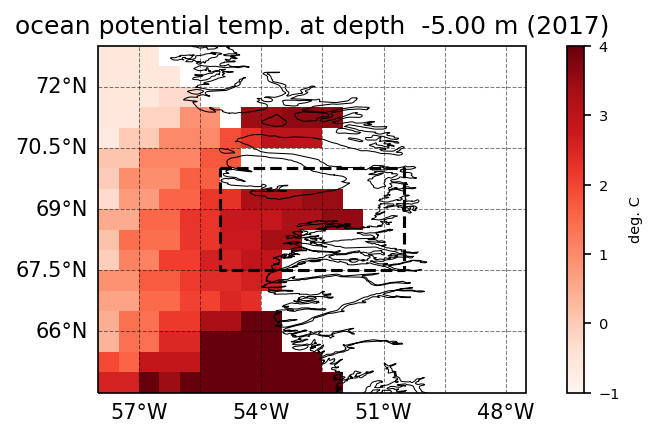

In [7]:
years = ['1992', '2017']

for year in years:
    s3_bucket = 's3://podaac-ops-cumulus-protected/ECCO_L4_TEMP_SALINITY_05DEG_MONTHLY_V4R4/*' + year + '-07*nc'
    s3_files = fs.glob(s3_bucket)

    file = fs.open(s3_files[0])
    ds = xr.open_dataset(file)
    depth = ds.Z.values
    lat = ds.latitude.values
    lon = ds.longitude.values
    theta = ds.THETA.values[0,:,:]
    ds.close()

    # Plot ocean potential temperature at the upper-most depth (i.e., the surface)
    fig = plt.figure(figsize=(7,3), dpi=150)
    ax = plt.axes(projection=ccrs.PlateCarree(), \
                  extent=[np.floor(ul[0]), np.ceil(lr[0]), np.floor(ul[1]), np.ceil(lr[1])])

    pc = ax.pcolormesh(lon, lat, theta[0,:,:], cmap=plt.cm.Reds, transform=ccrs.PlateCarree(), vmin=-1, vmax=+4)
    ax.plot([ul[0], lr[0], lr[0], ul[0], ul[0]], [ul[1], ul[1], lr[1], lr[1], ul[1]], 'k--', markersize=5, zorder=100, transform=ccrs.PlateCarree())

    lonm, latm = np.meshgrid(lon,lat)

    c = plt.colorbar(pc)
    c.ax.tick_params(labelsize=7)
    c.set_label('deg. C', size=7)

    ax.coastlines(resolution='10m', zorder=7, linewidth=0.5)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='black', alpha=0.5, linestyle='--', draw_labels=True)
    gl.top_labels   = False
    gl.right_labels = False
    
    ax.set_title('ocean potential temp. at depth {:+6.2f} m ({:s})'.format(depth[0], year))
    ax.set_xlim(ul[0]-3, lr[0]+3)
    ax.set_ylim(lr[1]-3, ul[1]+3)
    

## Calculate ocean thermal forcing time series from monthly ECCOv4r4 data
Now the fun part: loop through all ECCO data and calculate monthly thermal forcing. Here, we calculate the mean thermal forcing inside of our bounding box and write the output to a text file.

**Note:** if the processing in the cell below is stuck, it may be beacuse the EDL credentials have expired (they have a time limit). To refresh, restart the kernel and rerun this notebook from the beginning.

In [8]:
# Loop through files year by year
years = range(1992,2018)
months = range(12)

TF_avg = list()
for year in progressbar.progressbar(years):
    # Get list of ECCO files for given year
    s3_bucket = 's3://podaac-ops-cumulus-protected/ECCO_L4_TEMP_SALINITY_05DEG_MONTHLY_V4R4/*{:d}*nc'.format(year)
    s3_files = fs.glob(s3_bucket)

    # Create a fileset (a list of open files)
    fileset = [fs.open(file) for file in s3_files]

    # Open all files using xarray open_mfdataset
    ds = xr.open_mfdataset(fileset,
                               combine='by_coords',
                               mask_and_scale=True,
                               decode_cf=True,
                               chunks='auto')

    if len(TF_avg) == 0:
        # Read in coordinate values
        depth = ds.Z.values
        lat = ds.latitude.values
        lon = ds.longitude.values

        # Subset by depth, lat, lon
        z_idx = np.where( (depth <= depth_min) & (depth >= depth_max) )[0]
        lon_idx = np.where( (lon >= ul[0]) * (lon <= lr[0]) )[0]
        lon_min = lon_idx[0]; lon_max = lon_idx[-1]+1
        lat_idx = np.where( (lat <= ul[1]) * (lat >= lr[1]) )[0]
        lat_min = lat_idx[0]; lat_max = lat_idx[-1]+1
    
    # Loop through months of the year
    for month in months:
        theta = ds.THETA[month, z_idx, lat_min:lat_max, lon_min:lon_max].values
        salt  = ds.SALT [month, z_idx, lat_min:lat_max, lon_min:lon_max].values
        
        # Calculate TF at every ECCO grid cell and depth
        TF = np.empty(theta.shape)
        for i in range(TF.shape[0]):
            for j in range(TF.shape[1]):
                for k in range(TF.shape[2]):
                    TF_ijk = thermal_forcing(lat[j], depth[i], theta[i,j,k], salt[i,j,k])
                    TF[i,j,k] = TF_ijk
                    
        # Calculate the average thermal forcing within the bounding box
        TF_avg.append(np.nanmean(TF, axis=(0,1,2)))
    
    # Close the dataset
    ds.close()

# Convert TF_avg to numpy array
TF_avg = np.array(TF_avg)


100% (26 of 26) |########################| Elapsed Time: 0:11:19 Time:  0:11:19


## Plot time series of ocean thermal forcing

Text(0, 0.5, 'TF (deg. C)')

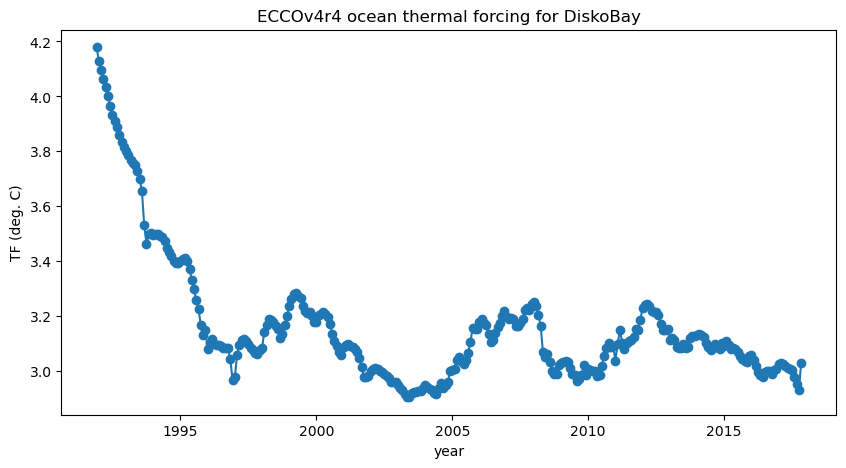

In [9]:
# Convert years and months to fractional years for plotting
times = list()
for year in years:
    for month in months:
        times.append(year + (month-1)/12)
times = np.array(times)

fig = plt.figure(figsize=(10,5))
plt.plot(times, TF_avg, 'o-')
plt.title('ECCOv4r4 ocean thermal forcing for {:s}'.format(regionname))
plt.xlabel('year')
plt.ylabel('TF (deg. C)')
